# Starbucks Capstone Challenge

## Data Exploration

In this project, I'm going to build a machine learning model to predict how much will a customer spend at Starbucks and what kind of offer will be more appropriate to send to a customer.

Starbucks dataset contains three json files:
* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

The schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

---


### Loading Python Resources

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Retrieving the Data

In [2]:
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

Displays the first few lines of each file:

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


Starbucks dataset contains three separate files. First I will combine the variables into a format that I can use in my model which will be contributed based on user information, so it's better to integrate the data of `transcript` and `portfolio` into `profile`.

### Preprocessing the Data

In both `profile` and `transcript`, ids are long strings, it's not easy to identify each user. So in next cells I'm going to replace user ids with integers. Then I can check each user's records easily.

In [6]:
# replace user ids
person_id_dict = pd.Series(profile['id']).to_dict()
person_id = {value: key for key, value in person_id_dict.items()}

profile['id'] = profile['id'].replace(person_id)
transcript['person'] = transcript['person'].replace(person_id)

In [7]:
# check one user's transcript
transcript.loc[transcript['person'] == 0]

,person,event,value,time
53174,0,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},168
85290,0,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},216
110828,0,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},336
130147,0,offer viewed,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},348
135224,0,transaction,{'amount': 0.35000000000000003},360
150596,0,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},408
163374,0,offer viewed,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},408
167626,0,transaction,{'amount': 0.74},414
182544,0,transaction,{'amount': 1.8900000000000001},444
201570,0,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},504


The column `value` is in format dictionary and can be considered as additional information for the column `event`. If a user behavior is related to an offer, the `value` will be the id corresponding to this offer. And if a user have purchased a product, the `value` will be the amount this user spent.

In this project, I want to predict how much a user spend at Starbucks during the test. I need to separate the purchase information from `transcript` and calculate the total amount spent by each customer.

In [8]:
# create a dataframe trans
trans = transcript.loc[transcript['event'] == 'transaction']

num_trans = trans.shape[0]

# get amount value from dict & create a list
amount = []
for i in range(num_trans):
    amount.append(trans['value'].iloc[i]['amount'])

# add the list to trans and drop column value
trans.insert(loc=4, column='amount', value=amount)
trans = trans.drop(labels=['value'], axis=1)

A sub-set `trans` is created containing all records of transaction. Now I can calculate the amount of each user using the `calculate_amount` function which takes in a user id and `trans` data, and returns the amount of this user.

In [9]:
def calculate_amount(id, trans_df):
    """ Given an id and a dataframe, calculate the total amount of money a person spent at Starbucks
    :param id: int, person id
    :param trans_df: dataframe, transcript with information of amount
    :return: float, the total amount of money the person (id) spent
    """
    return trans_df.loc[trans_df['person'] == id]['amount'].sum()


In [10]:
# create a new list containing the amount of user
amount = []
num_customer = profile.shape[0]
for i in range(num_customer):
    amount.append(calculate_amount(i, trans))

# add the list to profile
profile.insert(loc=5, column='total_amount', value=amount)

In [11]:
profile.head()

,gender,age,id,became_member_on,income,total_amount
0,None,118,0,20170212,NaN,20.40
1,F,55,1,20170715,112000.0,77.01
2,None,118,2,20180712,NaN,14.30
3,F,75,3,20170509,100000.0,159.27
4,None,118,4,20170804,NaN,4.65


Then I'll use the same method to handle the data associated offer status in `transcript` and create a sub-set `event` containing the rest of data in `transcript`. To start with, like user id, replace offer id with integers in `portfolio` and change the format of `value` in `transcript`.

In [12]:
# create a dataframe event
event = transcript.loc[transcript['event'] != 'transaction']
num_event = event.shape[0]

# get offer id from dict
for i in range(num_event):
    event['value'].iloc[i]['offer_id'] = event['value'].iloc[i].pop(list(event['value'].iloc[i].keys())[0])

offer_id = []
for i in range(num_event):
    offer_id.append(event['value'].iloc[i]['offer_id'])

# add a column offer id to event and drop column value
event.insert(loc=4, column='offer_id', value=offer_id)
event = event.drop(labels=['value'], axis=1)


In [13]:
# replace offer id in event & portfolio
offer_dict = {
    'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo1',
    '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo2',
    '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo3',
    'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo4',
    '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount1',
    '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount2',
    'fafdcd668e3743c1bb461111dcafc2a4': 'discount3',
    '2906b810c7d4411798c6938adc9daaa5': 'discount4',
    '3f207df678b143eea3cee63160fa8bed': 'info1',
    '5a8bc65990b245e5a138643cd4eb9837': 'info2',
}
portfolio['id'] = portfolio['id'].replace(offer_dict)
event['offer_id'] = event['offer_id'].replace(offer_dict)

In [14]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,bogo1
1,10,"[web, email, mobile, social]",10,5,bogo,bogo2
2,0,"[web, email, mobile]",0,4,informational,info1
3,5,"[web, email, mobile]",5,7,bogo,bogo3
4,5,"[web, email]",20,10,discount,discount1


In [15]:
event.head()

,person,event,time,offer_id
0,3,offer received,0,bogo3
1,4,offer received,0,discount1
2,5,offer received,0,discount4
3,6,offer received,0,discount3
4,7,offer received,0,bogo2


Considering offer type is also an importance feature and I will explain about it in the next part. Now add a new column `offer_type` in `event`.

In [16]:
# create a dict of offer & type
offer_type = {portfolio['id'][i]: portfolio['offer_type'][i] for i in range(portfolio.shape[0])}

# add a column offer_type
event['offer_type'] = ''
for i in range(event.shape[0]):
    event.iloc[i, 4] = offer_type[event.iloc[i, 3]]

After dividing `transcript` into two dataframes `trans` and `event` and analyzing them seprtately, I can merge the two dataframes and get a new transcript dataframe. Then sort `transcript_new` based on user id and time.

In [17]:
transcript_new = pd.concat([trans, event], axis=0)
transcript_new = transcript_new.sort_values(by=['person', 'time'], ascending=[True, True])

In [18]:
transcript_new.head()

,person,event,time,amount,offer_id,offer_type
53174,0,offer received,168,NaN,discount4,discount
85290,0,offer viewed,216,NaN,discount4,discount
110828,0,offer received,336,NaN,discount1,discount
130147,0,offer viewed,348,NaN,discount1,discount
135224,0,transaction,360,0.35,NaN,NaN


In this case, offer type can be regarded as two categories. The type of bogo/discount has specific difficulty and reward. The type information is like an advertisement. This can also be demonstrated from the data. In addition, the actual transactions can be more complicated.

In [19]:
transcript_new.loc[transcript_new['offer_id'] == 'bogo1']['event'].value_counts()

offer received     7658
offer viewed       6716
offer completed    3688
Name: event, dtype: int64

In [20]:
transcript_new.loc[transcript_new['offer_id'] == 'info1']['event'].value_counts()

offer received    7617
offer viewed      4144
Name: event, dtype: int64

We can see that if an offer is type bogo or discount, when offers are sent to users, it can be three status: offer received, offer viewed and offer completed. But for the offers of type information, there are only two possible status: offer received and offer viewed. Because the offer doesn't have an difficulty or reward, there is no condition to determine whether an offer is completed. 

Intuitively, we can know whether a transaction is influenced by an offer by comparing the time. Offers have a duration, and we know when a user reveives an offer, we can calculate a validity period. If a user opens the offer and has records of transactions during this validity period, we can assume that the user is influenced by this offer. If we check the transcript of some users, we'll find that it's not easy to identify the influences of the offers.

In [21]:
# get one user's transcript
def user_transcript(user_id, transcript):
    """ Given a user id, create a dataframe containing all actions of this user
    :param user: int
    :param transcript: a dataframe (transcript)
    :return: a subset of the dataframe corresponding to the given id
    """
    user_actions = transcript.loc[transcript['person'] == user_id]
    return user_actions

In [22]:
person0 = user_transcript(0, transcript_new)
print(person0)

        person            event  time  amount   offer_id offer_type
53174        0   offer received   168     NaN  discount4   discount
85290        0     offer viewed   216     NaN  discount4   discount
110828       0   offer received   336     NaN  discount1   discount
130147       0     offer viewed   348     NaN  discount1   discount
135224       0      transaction   360    0.35        NaN        NaN
150596       0   offer received   408     NaN  discount3   discount
163374       0     offer viewed   408     NaN  discount3   discount
167626       0      transaction   414    0.74        NaN        NaN
182544       0      transaction   444    1.89        NaN        NaN
201570       0   offer received   504     NaN  discount2   discount
214274       0     offer viewed   504     NaN  discount2   discount
218392       0      transaction   510    5.04        NaN        NaN
230411       0      transaction   534    0.38        NaN        NaN
237364       0      transaction   552    2.12   

From user 0's transcript, we can see this user received respectively discount3 and discount2 at time 408 and 504. The three transactions which happened from 510 to 552 helped this user completed the two offers at the same time. 

This also happens for offers of type information. It's possible for a user to receive more than one offer at the same time. Therefore we can't recognise which transaction is affected by which offer.

The following situations also make it difficult to identify whether a user is affected by an offer or by which a user is affected:
* Transactions happens during a validity period of an offer, but the offer isn't completed.
* An offer has been completed but the user never opens the offer.

The only thing we know for sure is that, when an offer is completed, the user has spent at least an amount of money which is equal to the difficulty of this offer.

If a bogo/discount offer isn't completed, the transactions happens during the validity period might be considered as transactions affected by an advertisement. So here I calculate the amount and percentage of completed offers.

In [23]:
# calculate completed offer difficulty
event_completed = event.loc[event['event'] == 'offer completed']

offer_difficulty = {portfolio['id'][i]: portfolio['difficulty'][i] for i in range(portfolio.shape[0])}

difficulty = []
for i in range(event_completed.shape[0]):
    difficulty.append(offer_difficulty[event_completed.iloc[i, 3]])

event_completed.insert(loc=5, column='amount', value=difficulty)    
    
offer_amount = []
for i in range(num_customer):
    offer_amount.append(calculate_amount(i, event_completed))

# add a new column offer_amount & percentage
profile.insert(loc=6, column='offer_amount', value=offer_amount)

percent = []
for i in range(num_customer):
    if profile.iloc[i, 6] == 0:
        percent.append(0)
    elif profile.iloc[i, 6] / profile.iloc[i, 5] < 1:
        percent.append(profile.iloc[i, 6] / profile.iloc[i, 5])
    else:
        percent.append(1)  

profile.insert(loc=7, column='p_completed', value=percent)

The dataset description doesn't mention the rules for sending offers to customers. However, from the informations wo got above, we know that the frequency users receive the offers is quite different. This may influence the amount users spend at Starbucks. A user who receives more offers may buy more products. Now I want to count the number of times users have received offers and the proportion of offers viewed.

In [24]:
def count_offers(user_transcript, offer_status):
    """ Given a user's transcript, count how many times the status appear
    :param user_transcript: dataframe, a user transcript
    :param offer_status: str, 'offer received' or 'offer viewed'
    :return: int, times the str appears
    """
    status_df = user_transcript.loc[user_transcript['event'] == offer_status]
    return status_df.shape[0]

In [25]:
# count how many times a user receives offers
n_received = []
n_viewed = []
for i in range(num_customer):
    user_event = user_transcript(i, event)
    n_received.append(count_offers(user_event, 'offer received'))
    n_viewed.append(count_offers(user_event, 'offer viewed'))
    
profile.insert(loc=8, column='n_received', value=n_received)
profile.insert(loc=9, column='n_viewed', value=n_viewed)

p_viewed = []
for i in range(num_customer):
    if profile.iloc[i, 9] == 0:
        p_viewed.append(0)
    else:
        p_viewed.append(profile.iloc[i, 9] / profile.iloc[i, 8])

profile.insert(loc=10, column='p_viewed', value=p_viewed)


Finally, drop the column of `offer_amount` and `n_viewed`. And the variable `id` is no longer useful.

In [26]:
# drop the amount of completed offers
profile = profile.drop(labels=['offer_amount', 'n_viewed', 'id'], axis=1)
profile.head()

,gender,age,became_member_on,income,total_amount,p_completed,n_received,p_viewed
0,None,118,20170212,NaN,20.40,0.833333,5,1.0
1,F,55,20170715,112000.0,77.01,0.064927,2,0.0
2,None,118,20180712,NaN,14.30,0.000000,2,1.0
3,F,75,20170509,100000.0,159.27,0.125573,4,1.0
4,None,118,20170804,NaN,4.65,0.000000,5,0.6


In [27]:
profile.isna().sum()

gender              2175
age                    0
became_member_on       0
income              2175
total_amount           0
p_completed            0
n_received             0
p_viewed               0
dtype: int64

In [28]:
profile.loc[profile['age'] == 118]

,gender,age,became_member_on,income,total_amount,p_completed,n_received,p_viewed
0,None,118,20170212,NaN,20.40,0.833333,5,1.00
2,None,118,20180712,NaN,14.30,0.000000,2,1.00
4,None,118,20170804,NaN,4.65,0.000000,5,0.60
6,None,118,20170925,NaN,0.00,0.000000,5,1.00
7,None,118,20171002,NaN,0.24,0.000000,5,0.80
...,...,...,...,...,...,...,...,...
16980,None,118,20160901,NaN,25.25,0.198020,5,0.60
16982,None,118,20160415,NaN,31.02,0.548034,4,0.75
16989,None,118,20180305,NaN,0.76,0.000000,5,1.00
16991,None,118,20160116,NaN,21.88,0.000000,4,0.25


### Missing Values
We can see that there are missing values and outliers in the dataframe. `gender` and `income` have 2175 missing values for the same samples. 118 appearing in these samples is obviously a default value for the variable `age`. In this case, if I replace all missing values with the same value of mean, median or mode, these samples will be considered to be similar. This might affect the accuracy of my model. Thus I decide to delete these samples. After deleting miss values, `profile` has 14825 samples left.

In [29]:
profile = profile.dropna()

In general, the length of time a person becomes a member will influence user behavior. But in this dataset, the time when this test started is not provided. The date when a user created an account i.e. the varialbe `became_member_on` doesn't seem useful. So I delete this variable.

In [30]:
profile = profile.drop(labels=['became_member_on'], axis=1)

In [31]:
profile = profile.reset_index(drop=True)

In [39]:
path = '/Users/haoyun/Documents/ML-U/starbucks/profile.csv'
profile.to_csv(path, index=False)

---
## Exploratory Visualization

Since I'm going to predict the amount users spend at Starbucks and the probability users complete a bogo/discount offer, target variables are `total_amount` and `p_completed`. Now I want to get more information about features in `profile` by making visualizations.
### Univariate Analysis

In [41]:
profile = pd.read_csv('profile.csv')

In [42]:
gender = profile['gender'].to_numpy()
age = profile['age'].to_numpy()
income = profile['income'].to_numpy()
total_amount = profile['total_amount'].to_numpy()
p_completed = profile['p_completed'].to_numpy()
n_received = profile['n_received'].to_numpy()
p_viewed = profile['p_viewed'].to_numpy()

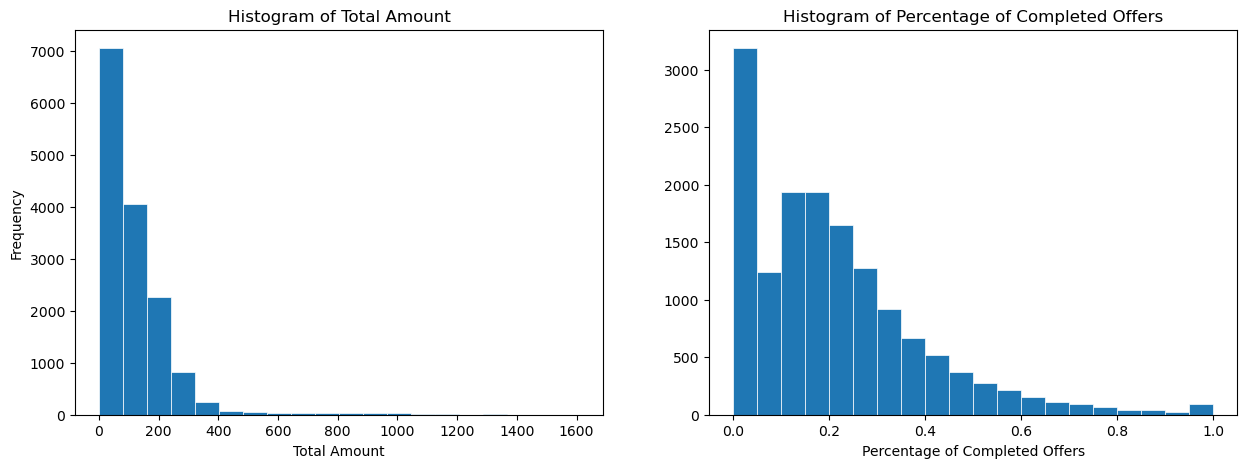

In [43]:
# show the distributions of target features: total_amount and p_completed
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(total_amount, bins=20, linewidth=0.5, edgecolor='white')
ax[0].set_xlabel('Total Amount')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of Total Amount')

ax[1].hist(p_completed, bins=20, linewidth=0.5, edgecolor='white')
ax[1].set_xlabel('Percentage of Completed Offers')
ax[1].set_title('Histogram of Percentage of Completed Offers')

plt.show()

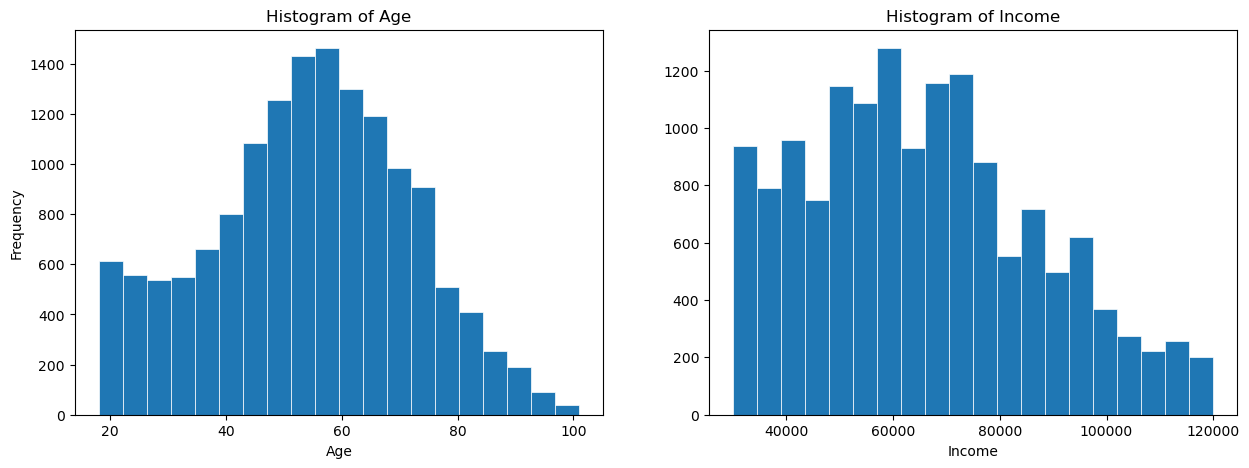

In [44]:
# show the distributions of input variables:
# age & income
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
                       
ax[0].hist(age, bins=20, linewidth=0.5, edgecolor='white')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of Age')

ax[1].hist(income, bins=20, linewidth=0.5, edgecolor='white')
ax[1].set_xlabel('Income')
ax[1].set_title('Histogram of Income')

plt.show()

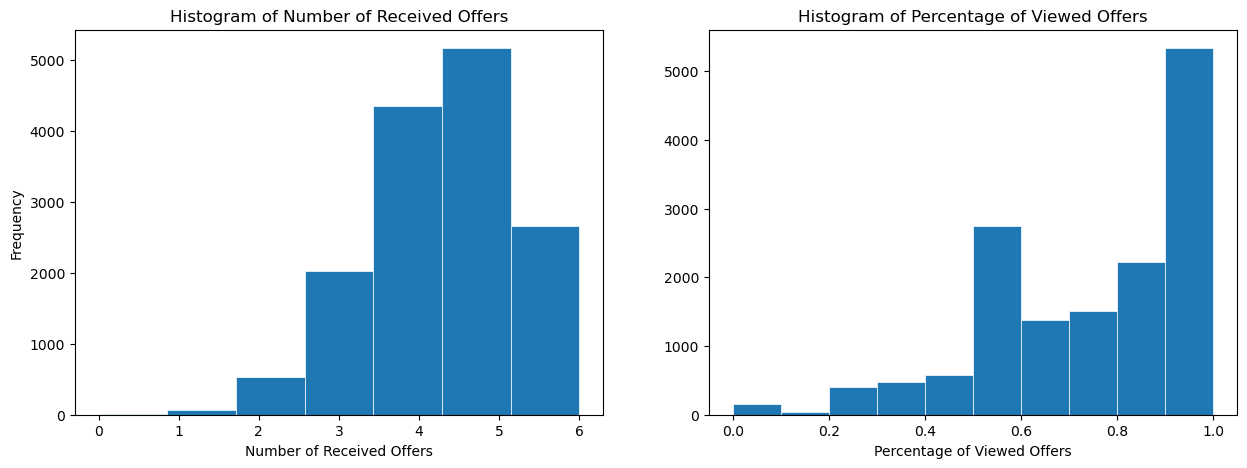

In [45]:
# show the distributions of input variables:
# n_received & p_viewed
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(n_received, bins=7, linewidth=0.5, edgecolor='white')
ax[0].set_xlabel('Number of Received Offers')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of Number of Received Offers')

ax[1].hist(p_viewed, bins=10, linewidth=0.5, edgecolor='white')
ax[1].set_xlabel('Percentage of Viewed Offers')
ax[1].set_title('Histogram of Percentage of Viewed Offers')

plt.show()

### Bi-variate Analysis

To start with, calculat the correlation coefficient between each feature.

In [46]:
profile.corr()

,age,income,total_amount,p_completed,n_received,p_viewed
age,1.000000,0.306703,0.105787,-0.001228,-0.005827,0.049157
income,0.306703,1.000000,0.315033,-0.052571,-0.006450,0.069018
total_amount,0.105787,0.315033,1.000000,-0.168666,0.090215,0.175591
p_completed,-0.001228,-0.052571,-0.168666,1.000000,0.187172,-0.000305
n_received,-0.005827,-0.006450,0.090215,0.187172,1.000000,-0.061819
p_viewed,0.049157,0.069018,0.175591,-0.000305,-0.061819,1.000000


Age and income have the largest correlation coefficient. This is normal because young people always have less work experience and lower income. 

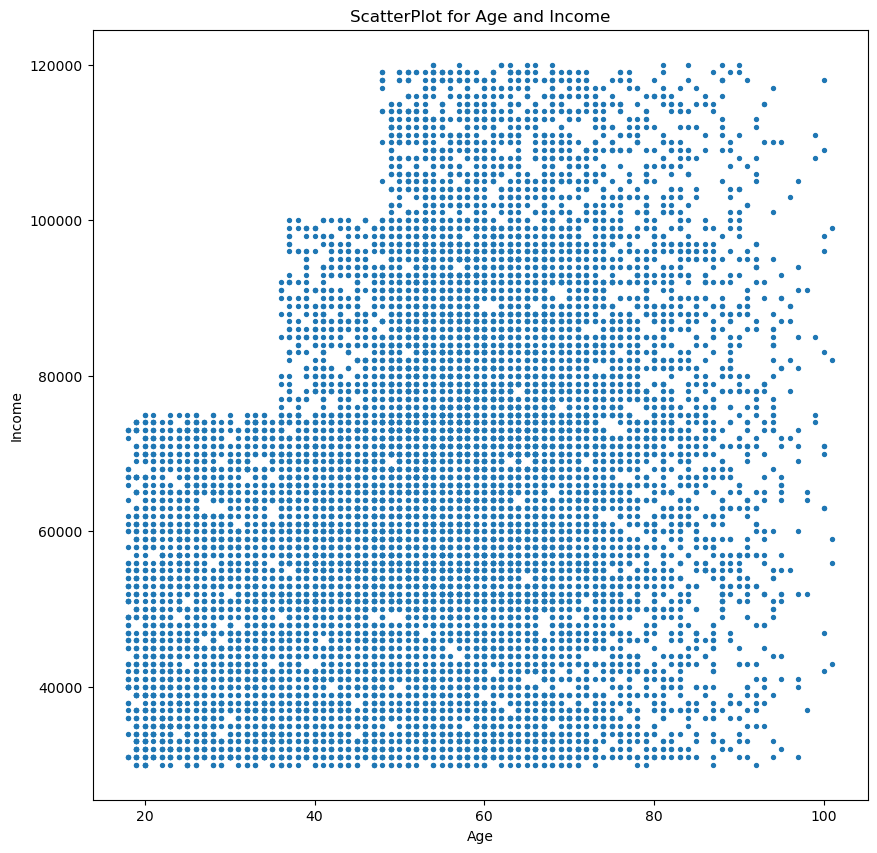

In [53]:
# age & income
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(age, income, s=8)
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('ScatterPlot for Age and Income')
plt.show()

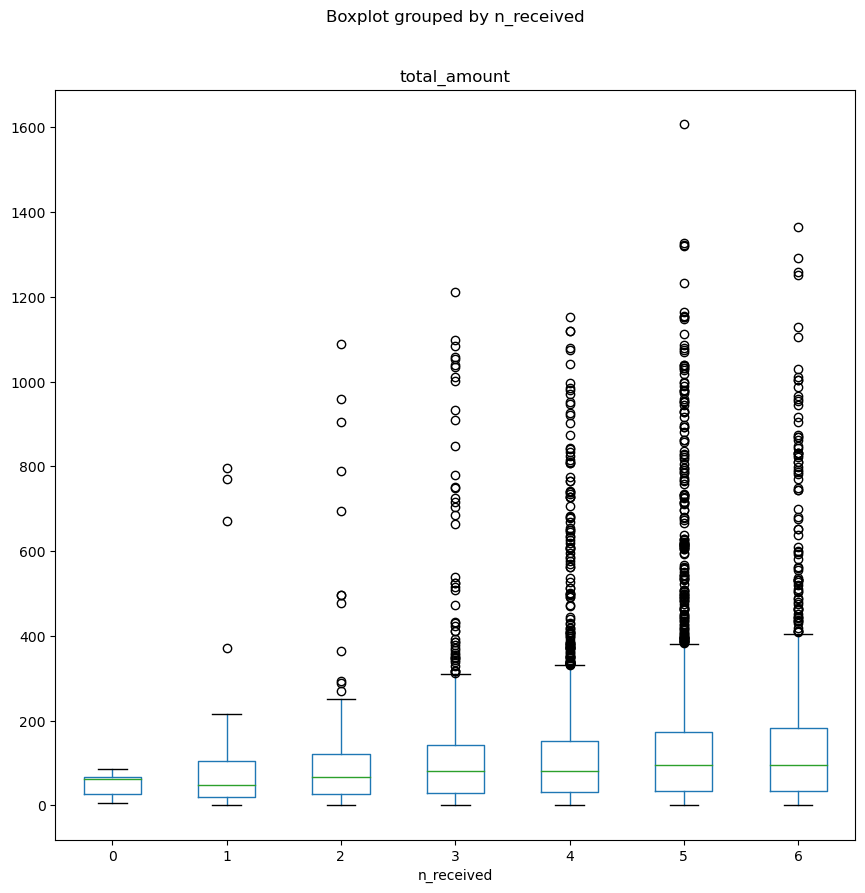

In [48]:
# n_received & total_amount
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
profile.boxplot(column='total_amount', by='n_received', ax=ax, grid=False)
plt.show()

The correlation between n_received and total_amount is exactly as expected. The more customers receive offers, the more money they will spend.

In [49]:
# gender & target variables
group = profile.groupby('gender')
group.mean().iloc[0, 1:].to_numpy()
means = group.mean()

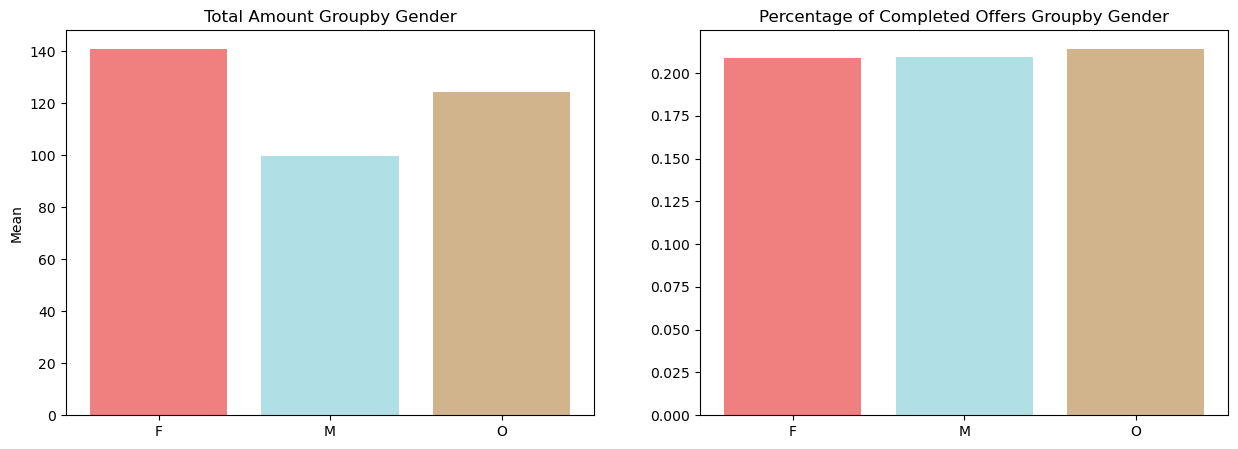

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

labels = ['F', 'M', 'O']
color = ['lightcoral', 'powderblue', 'tan']

ax[0].bar(labels, means.iloc[:, 2].to_numpy(), color=color)
ax[0].set_ylabel('Mean')
ax[0].set_title('Total Amount Groupby Gender')

ax[1].bar(labels, means.iloc[:, 3].to_numpy(), color=color)
ax[1].set_title('Percentage of Completed Offers Groupby Gender')

plt.show()

### Outliers
The outliers will be treated before contributing the models, i.e. this part will be in the notebook of model.